<a href="https://colab.research.google.com/github/Rogerio-mack/Deep-Learning-I/blob/main/T4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right"> 

<h1 align=left><font size = 8, style="color:rgb(200,0,0)"><b>Inteligência Artificial</b></font></h1> 
<h1 align=left><font size = 6, style="color:rgb(0,0,0)"><b>Deep Learning</b></font></h1> 

# 4. Modelos Sequenciais e Classificação com TensorFlow
Professor(a): Rogério de Oliveira

<br>
<br>

---


# Introdução

Nesta trilha você vai estudar os modelos sequenciais de deep learning para classificação. Os modelos sequenciais são redes em camadas, semelhante ao que vimos antes (redes feedforwad e o Modelo Multilayer Perceptron), que agora vamos implementar empregando o `TensorFlow` e o `Keras`. 

# `Keras TensorFlow`

Você viu na trilha anterior que o `TensorFlow` (v2) é uma plataforma para programação diferenciável que combina habilidades de execução eficiente de operações sobre tensores em diversos dispositivos, o cálculo do gradiente de expressões diferenciáveis quaisquer e grafos e execução. O `Keras` é a API de alto nível do `TensorFlow 2`: uma interface mais acessível e bastante produtiva para resolver problemas de aprendizado profundo fornece abstrações a vários blocos de construção de modelos deep learning (transformações, camadas, treinamento etc.). O `Keras` funciona, assim, como um *wrapper* para a estrutura do `TensorFlow`. 

O comparativo abaixo ajuda a entender algumas das diferenças entre o  `TensorFlow`, o `Keras` e o `PyTorch` que estudaremos mais adiante. 

|   |	Keras	| Pytorch	| TensorFlow |
|---|-------|---------|------------|
| API Level |	High	|Low	|High and Low|
| Architecture	|Simple, concise, readable|	Complex, less readable	|Not easy to use |
| Datasets	|Smaller datasets	|Large datasets, high performance|	Large datasets, high performance |
| Debugging	|Simple network, so debugging is not often needed|	Good debugging capabilities	|Difficult to conduct debugging|
| Does It Have Trained Models?	|Yes	|Yes|	Yes|
| Popularity	|Most popular	|Third most popular	|Second most popular|
| Speed	|Slow, low performance|	Fast, high-performance	|Fast, high-performance| 
| Written In	|Python	|Lua	|C++, CUDA, Python|

Existem, desse modo, três maneiras de criar modelos de redes profundas com o  `Keras TensorFlow`:

* O **Modelo Sequencial**, que define de modo direto camadas de neurônios organizadas em sequência, e está limitado a uma entrada e saída única da rede.

* A **API Funcional**, que é uma API fácil de usar e com todos os recursos e que oferece suporte a arquiteturas de modelo arbitrárias. 

* O modelo de **Subclasse**, onde você pode implementar tudo do zero, por conta própria,, criando quaisquer novos modelos de rede aproveitando a infraestrutura de programação diferenciável do TensorFlow. 

O Modelo Sequencial é o mais simpes de usar e aqui vamos no deter principalmente nesse modelo. Mas é importante que você conheça as outras formas de programação do `Keras TensorFlow`. Boa parte do sucesso e popularidade do `TensorFlow` se deve a essas interfaces mais amigáveis que implementa. Outros  frameworks não implementam essas interfaces e será útil você conhecer a interface de Subclasses que é a única que você encontrará, por exemplo, no `Pytorch`.  A interface de Subclasses é a de mais baixo nível, mas é também a que fornece mais flexibilidade permitindo que você crie conexões arbitrárias entre os neurônios, funções de custo próprias etc. A API Funcional, em um nível intermediário é, em princípio, uma interface com o objetivo de atender a indústria.

# Exemplo: Classificação `biopsy`

Vamos empregar aqui um conhecido conjunto de dados para problemas de classificação, `biopsy`, para desenvolver aqui modelos de classificação dos tumores com o `Keras TensorFlow` empregando as 3 formas desenvolvimento de modelos que vimos acima.

> *Este banco de dados de câncer de mama foi obtido dos Hospitais da Universidade de Wisconsin, em Madison, do Dr. William H. Wolberg. Ele avaliou biópsias de tumores de mama em 699 pacientes até 15 de julho de 1992; cada um dos nove atributos foi pontuado em uma escala de 1 a 10, e o resultado também é conhecido. Existem 699 linhas e 11 colunas.*



## Explorando os Dados

In [ ]:
import pandas as pd
from IPython.display import display

df = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/MASS/biopsy.csv', index_col=0)
display(df.head())

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,class
1,1000025,5,1,1,1,2,1.0,3,1,1,benign
2,1002945,5,4,4,5,7,10.0,3,2,1,benign
3,1015425,3,1,1,1,2,2.0,3,1,1,benign
4,1016277,6,8,8,1,3,4.0,3,7,1,benign
5,1017023,4,1,1,3,2,1.0,3,1,1,benign


O conjunto de dados classifica cada uma das instâncias como `benign` ou `malignant` e será nosso conjunto de treinamento para implementar um modelo neural em camadas de classificação dos tumores à exemplo de modelos MLP.

In [ ]:
df['class'].value_counts()

benign       458
malignant    241
Name: class, dtype: int64

## Preparando os Dados 

A coluna `ID` não faz sentido para o nosso modelo e será excluída dos dados de entrada. Como outros modelos, modelos de redes neurais não dão suporte a valores ausentes e optamos aqui arbitrariamente por imputar novos valores aos valores nulos. 

In [ ]:
df = df.drop(columns='ID')
print( df.isna().sum(), '\n', 'total NA =' , df.isna().sum().sum() )
df.V6 = df.V6.fillna( df.V6.mean() )
print( '\n', 'total NA =' , df.isna().sum().sum() )

V1        0
V2        0
V3        0
V4        0
V5        0
V6       16
V7        0
V8        0
V9        0
class     0
dtype: int64 
 total NA = 16

 total NA = 0


O `TensorFlow` requer entradas de dados unicamente numéricas e, portanto, faremos o encode do atributo classe.

In [ ]:
df['class'] = df['class'].map({'benign': 0, 'malignant': 1})

X = df.drop('class', axis=1)
y = df[['class']]

Aqui, como faremos uma classificação binária, podemos empregar a codificação acima. Mas o mais comum, para problemas de classificação multiclasse, será o hot encode da classe.

Definidos e tratados os dados de entrada `X` e saída `y` do nosso conjunto de exemplos, podemos então separar os conjuntos de treinamento e teste. 

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [ ]:
display(X_train.head())
display(y_train.head())

,V1,V2,V3,V4,V5,V6,V7,V8,V9
35,3,1,2,1,2,1.0,2,1,1
34,2,1,1,2,2,1.0,3,1,1
286,8,10,10,10,8,10.0,10,7,3
454,4,5,5,8,6,10.0,10,7,1
296,5,5,7,8,6,10.0,7,4,1


,class
35,0
34,0
286,1
454,1
296,1


## Modelo Sequencial

Estamos com os dados prontos agora para criar modelos neurais. Vamos começar pela solução mais simples que é empregar o Modelo Sequencial do `Keras TensorFlow`. Não discutimos aqui todos os parâmetros de cada função e você pode consultar a documentação do `Keras` e do `TensorFlow` para saber mais sobre essas funções. Mas vamos apresentar e discutir os principais pontos para fazer o aprendizado de classificação do nosso conjunto de dados `biopsy` e aprender, assim, como criar modelos com sequenciais de modo geral.

### Imports

O `import tensorflow as tf` pode muitas vezes não ser necessário quando empregamos a interface de alto nível do Modelo Sequencial. Mas empregaremos ele mais adiante e, por isso, incluímos aqui.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

### Declarando as Camadas

As camadas são definidas são adicionadas ao Modelo Sequencial incluindo-se `layers` que são adicionados na mesma sequencia em que aparecem.

In [ ]:
model = keras.Sequential([
    layers.Dense(8, activation='sigmoid', input_shape=[9]),
    layers.Dense(1, activation='sigmoid'),
])

Além de neurônios do tipo Perceptron, existem camadas de vários tipos de *neurônios* como camadas de convolução (`layers.Conv1D`, `layers.Conv2D`) ou de transformação, como levar dados de uma matriz 2D para um vetor 1D (`layers.Flatten`) muito empregados em redes profundas. As camadas `Dense` correspondem às camadas que já conhecemos de neurônios de redes MLP. Nessa camada você pode configurar o número de neurônios (`units`), a função de ativação, entre outros parâmetros. A primeira camada deve incluir o tamanho da entrada dos dados, isto é o número de atributos de entrada. No nosso caso são 9 atributos, e poderíamos igualmente ter empregado `X_train.shape[1]`.

Da segunda camada em diante você não precisa especificar o tamanho da entrada. O modelo assumirá que as entradas correspondem às saídas da camada anterior. É por isso que esse modelo não permite alterar a estrutura da rede incluindo outras entradas ou produzindo outras saídas da rede. 

Para classificicação binária e modelos de regressão podemos ter um único neurônio de saída. Para modelos multiclasse emprega-se um neurônio para cada classe de dados na saída. As demais camadas, entre a camada de entrada e saída, são arbitrárias.


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 80        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


O método `summary` fornece então o modelo construído. Note que existem $80 = 8 \times 10$ parâmetros, ou pesos, na primeira cada. Lembre-se, é uma combinação linear e há um peso para cada atributo e mais um parâmetro independente. 

O método `.add` pode ser empregado para adicionar camadas ao final do modelo e os comandos abaixo produzem o mesmo modelo construído anteriormente.

In [ ]:
model = keras.Sequential(layers.Dense(8, activation='sigmoid', input_shape=[9]))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 8)                 80        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


### Compilando o Modelo

O método `compile` permite definir vários parâmetros do modelo como o otimizador a ser empregado e a função custo que será otimizada. 

Abaixo empregamos o otimizador padrão (`rmsprop`). Como função custo empregamos a Entropia Cruzada ou *Cross Entropy*, uma métrica bastante empregada como função custo para problemas de classificação. Essa é uma medida bastante mais elaborada que a acuracidade que não detalharemos aqui e você pode consultar as referências ao final deste capítulo para saber mais sobre *Cross Entropy*. O parâmetro `metrics` permite ainda indicar métricas que desejamos produzir e salvar durante o treinamento do modelo e selecionamos aqui a acuracidade. 

In [ ]:
model.compile(
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

### Treinando o Modelo

Diversos parâmetros podem ter empregados para o treinamento do modelo. O método `.fit` recebe o conjunto de treinamento com suas entradas e saídas que podem estar no formato de `DataFrame` ou `Series` dados, como também em matrizes `Numpy` ou tensores. O `Keras` se encarrega de fazer a transformação desses dados para tensores e você, neste caso, não precisa se preocupar com isso. 

O pârametro `validation_split` é empregado para definir o percentual dos dados que será empregado como conjunto de validação ao longo do treinamento que será realizado em $n$ `epochs`. 

In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size=32,
    validation_split=0.3,
    epochs=20,
    verbose=1,  
)

Epoch 1/20
11/11 [==============================] - 1s 23ms/step - loss: 0.8633 - binary_accuracy: 0.3129 - val_loss: 0.7833 - val_binary_accuracy: 0.3810
Epoch 2/20
11/11 [==============================] - 0s 5ms/step - loss: 0.8093 - binary_accuracy: 0.3216 - val_loss: 0.7473 - val_binary_accuracy: 0.4150
Epoch 3/20
11/11 [==============================] - 0s 4ms/step - loss: 0.7696 - binary_accuracy: 0.3216 - val_loss: 0.7172 - val_binary_accuracy: 0.4218
Epoch 4/20
11/11 [==============================] - 0s 5ms/step - loss: 0.7347 - binary_accuracy: 0.3304 - val_loss: 0.6901 - val_binary_accuracy: 0.4422
Epoch 5/20
11/11 [==============================] - 0s 4ms/step - loss: 0.7031 - binary_accuracy: 0.3684 - val_loss: 0.6659 - val_binary_accuracy: 0.5306
Epoch 6/20
11/11 [==============================] - 0s 4ms/step - loss: 0.6741 - binary_accuracy: 0.5292 - val_loss: 0.6436 - val_binary_accuracy: 0.7347
Epoch 7/20
11/11 [==============================] - 0s 4ms/step - loss: 0.6

Aqui o parâmetro `batch_size` está com o valor padrão. Ele é o número de amostras que serão feitas por atualização de gradiente. Se não for especificado, o padrão será 32 e esse parâmetro pode ter um efeito muito grande sobre o desempenho e tempo do treinamento da rede. Indique 0 no `verbose` para inibir a saída para treinamentos longos.



### Reprodutibilidade

A reprodutibilidade no caso do `Keras TensorFlow`, sendo uma API e de alto nível é bastante difícil de ser alcançada e você pode ver o grande número de fóruns sobre isso na internet. Você pode testar e estratégias de *setar* do `Python`, do `Numpy` e mesmo do backend do `TensorFlow` não terão resultado aqui. Os modelos de redes profundas são naturalmente estocásticos e o fato de termos processos em paralelo (mesmo em CPUs) e ainda em GPUs dificulta ainda mais isso. Não vamos, portanto, nos preocupar com isso aqui. Os resultados do treinamento acima, portanto, devem diferir do que apresentamos aqui se você executá-los. 

### Curva de Apredizado

Você deve ter notado que fizemos uma atribuição do método `fit` para uma variável `history` acima. Isso é opcional. Se fizer, o histórico do treinamento com os valores da função de perda e das métricas selecionadas na compilação do modelo serão armazenadas a cada passo do treinamento. Podemos então construir um `DataFrame` a partir desses dados e exibir a curva de aprendizado. Essa curva fornece um instrumento muito útil para a análise do treinamento da rede e o ajuste de seus hiperparâmetros. 

In [ ]:
def display_hist(history):
  history_df = pd.DataFrame(history.history)
  display(history_df.head())
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot()
  history_df.loc[0:, ['binary_accuracy', 'val_binary_accuracy']].plot()

  print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))
  return

  

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.863288,0.312865,0.783349,0.380952
1,0.809289,0.321637,0.747279,0.414966
2,0.769562,0.321637,0.717152,0.421769
3,0.734709,0.330409,0.690147,0.442177
4,0.703115,0.368421,0.665934,0.530612


Best Validation Loss: 0.5109
Best Validation Accuracy: 0.8503


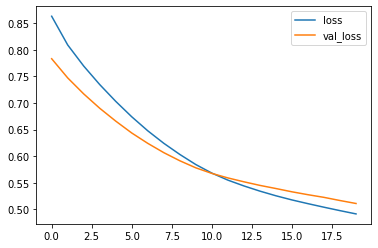

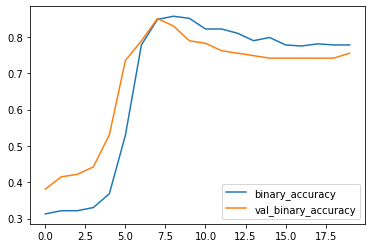

In [ ]:
display_hist(history)  

### Resultados

Podemos então avaliar os resultados do nosso modelo fazendo a predição do conjunto de teste selecionado anteriormente. 

Aqui podemos empregar as métricas usuais do `Scikit-Learn`. A predição, tendo um único neurônio de saída com a função sigmóide (ou logística) devolve um único valor entre $[0, 1]$ e podemos entender esse valor como a chance de ser a classe `1`.

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def print_results(y_test, y_pred):
  print('Matriz de Confusão: \n' , confusion_matrix(y_test, y_pred))
  print(classification_report(y_test, y_pred))
  print('Acuracidade: ' , accuracy_score(y_test, y_pred))
  return

In [ ]:
y_pred = model.predict(X_test) > 0.5

print_results(y_test, y_pred)


Matriz de Confusão: 
 [[130   1]
 [ 53  26]]
              precision    recall  f1-score   support

           0       0.71      0.99      0.83       131
           1       0.96      0.33      0.49        79

    accuracy                           0.74       210
   macro avg       0.84      0.66      0.66       210
weighted avg       0.81      0.74      0.70       210

Acuracidade:  0.7428571428571429


## Functional API 

O outro modo que temos é desenvolve o modelo no modo da API Funcional do `Keras TensorFlow`. 

Aqui você pode definir explicitamente para cada camada as entradas e direcionar as saídas de cada uma delas. Isso permite você criar modelos não sequenciais (veja referências no final do capítulo para alguns exemplos). 

O modelo abaixo é o mesmo que construímos antes, mas empregado a API Funcional do `Keras`. 


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

inputs = Input(shape=(9,)) # Retorna um tensor

out1 = Dense(8, activation='sigmoid')(inputs)
out2 = Dense(1, activation='sigmoid')(out1)

model = Model(inputs=inputs, outputs=out2)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 80        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


A compilação e treinamento do modelo podem seguir, então, do mesmo modo que no modelo anterior.

In [ ]:
model.compile(
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)


In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size=1,
    validation_split=0.3,
    epochs=20,
    verbose=1, 
)

Epoch 1/20
342/342 [==============================] - 1s 2ms/step - loss: 0.6427 - binary_accuracy: 0.6462 - val_loss: 0.5976 - val_binary_accuracy: 0.6327
Epoch 2/20
342/342 [==============================] - 0s 1ms/step - loss: 0.5481 - binary_accuracy: 0.6842 - val_loss: 0.5538 - val_binary_accuracy: 0.6259
Epoch 3/20
342/342 [==============================] - 0s 1ms/step - loss: 0.4945 - binary_accuracy: 0.6871 - val_loss: 0.5111 - val_binary_accuracy: 0.6259
Epoch 4/20
342/342 [==============================] - 1s 2ms/step - loss: 0.4466 - binary_accuracy: 0.7339 - val_loss: 0.4581 - val_binary_accuracy: 0.7551
Epoch 5/20
342/342 [==============================] - 0s 1ms/step - loss: 0.3949 - binary_accuracy: 0.8450 - val_loss: 0.4152 - val_binary_accuracy: 0.8095
Epoch 6/20
342/342 [==============================] - 0s 1ms/step - loss: 0.3475 - binary_accuracy: 0.8918 - val_loss: 0.3779 - val_binary_accuracy: 0.8503
Epoch 7/20
342/342 [==============================] - 1s 2ms/ste

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.642713,0.646199,0.597567,0.632653
1,0.548120,0.684211,0.553847,0.625850
2,0.494542,0.687135,0.511149,0.625850
3,0.446639,0.733918,0.458079,0.755102
4,0.394865,0.845029,0.415242,0.809524


Best Validation Loss: 0.2015
Best Validation Accuracy: 0.9388


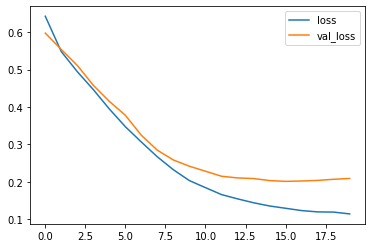

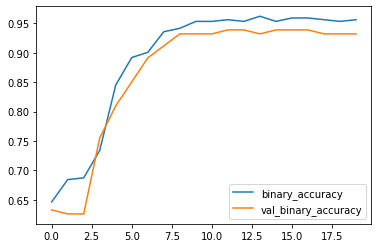

In [ ]:
display_hist(history)  

In [ ]:
y_pred = model.predict(X_test) > 0.5

print_results(y_test, y_pred)



Matriz de Confusão: 
 [[127   4]
 [  9  70]]
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       131
           1       0.95      0.89      0.92        79

    accuracy                           0.94       210
   macro avg       0.94      0.93      0.93       210
weighted avg       0.94      0.94      0.94       210

Acuracidade:  0.9380952380952381


Melhor ou pior reflete apenas o fato dos modelos terem sido inicializados diferentemente.

## Modelo de Subclasse 

O Modelo de Subclasse é o de mais baixo nível de programação mas é também o que dá mais flexibilidade na construção de quaisquer modelos. 

Esse modelo de construção é útil quando queremos criar arquiteturas próprias de rede o que é muito comum em problemas de redes profundas. Entendendo um pouco sobre esse modelo você poderá compreender como, por exemplo, é empregada a programação diferenciável do `TensorFlow` no aprendizado das redes. Nessa forma de programação você estará desenvolvendo o mesmo que o `Keras` emprega para construir os modelos anteriores. Isso também vai ajudar você a entender outros frameworks que não disponibilizam uma interface de alto nível como o `Keras`. 

### Estendendo a Classe `Model`

Podemos começar estendendo a classe `Model`. Aqui você pode definir as diferentes camadas que quer empregar (`__init__') e ordená-las da forma que julgar mais adequado, incluindo a definição de suas entradas e saídas (`call`).



In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

class MyModel(Model):
    
    def __init__(self, **kwargs):
        super(MyModel, self).__init__(**kwargs)
        self.dense1 = Dense(8, activation='sigmoid',input_shape=[9])
        self.dense2 = Dense(1, activation='sigmoid')        
        
    def call(self, inputs):
        out1 = self.dense1(inputs)
        return self.dense2(out1)

neural_net = MyModel(name='MyModel')

As classes acima implementam o mesmo modelo criado anterior nos modos Sequencial e API Funcional do `Keras`.

Para que você entendá melhor veja esse exemplo:

In [ ]:
X_test = tf.Variable(X_test)
neural_net(X_test)[0:10]



<tf.Tensor: shape=(10, 1), dtype=float32, numpy=
array([[0.47880572],
       [0.4470732 ],
       [0.43232813],
       [0.53112495],
       [0.46769917],
       [0.4470732 ],
       [0.5144075 ],
       [0.4470732 ],
       [0.47811368],
       [0.3556474 ]], dtype=float32)>

Apenas com a definição dessa classe a sua rede já está definida! A única coisa é que ela ainda não está treinada e os pesos são aleatórios. Mas podemos aplicar um conjunto de dados à rede e produzir o *forward* da rede, sua saída!

Aqui, entretanto, não temos o `Keras` para prover uma interface de abstração maior e precisamos transformar os dados que desejamos aplicar a rede para tensores. Exibimos apenas as 10 primeiras ocorrências da saída da rede para o nosso conjunto de teste.

### Treinamento não customizado

Podemos então compilar e treinar nosso modelo do mesmo modo que fizemos antes.

In [ ]:
neural_net.compile(
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)


In [ ]:
history = neural_net.fit(
    X_train, y_train,
    batch_size=1,
    validation_split=0.3,
    epochs=20,
    verbose=1,  
)

Epoch 1/20
342/342 [==============================] - 1s 2ms/step - loss: 0.5889 - binary_accuracy: 0.6959 - val_loss: 0.5828 - val_binary_accuracy: 0.6395
Epoch 2/20
342/342 [==============================] - 1s 2ms/step - loss: 0.4911 - binary_accuracy: 0.7047 - val_loss: 0.5223 - val_binary_accuracy: 0.7211
Epoch 3/20
342/342 [==============================] - 1s 2ms/step - loss: 0.4410 - binary_accuracy: 0.7632 - val_loss: 0.4755 - val_binary_accuracy: 0.7959
Epoch 4/20
342/342 [==============================] - 0s 1ms/step - loss: 0.3853 - binary_accuracy: 0.8538 - val_loss: 0.4581 - val_binary_accuracy: 0.7687
Epoch 5/20
342/342 [==============================] - 1s 2ms/step - loss: 0.3495 - binary_accuracy: 0.8596 - val_loss: 0.3892 - val_binary_accuracy: 0.8571
Epoch 6/20
342/342 [==============================] - 0s 1ms/step - loss: 0.2975 - binary_accuracy: 0.9035 - val_loss: 0.3430 - val_binary_accuracy: 0.8980
Epoch 7/20
342/342 [==============================] - 0s 1ms/ste

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,0.588915,0.695906,0.582839,0.639456
1,0.491087,0.704678,0.522323,0.721088
2,0.440953,0.763158,0.475475,0.795918
3,0.385305,0.853801,0.458147,0.768707
4,0.349458,0.859649,0.389224,0.857143


Best Validation Loss: 0.2277
Best Validation Accuracy: 0.9320


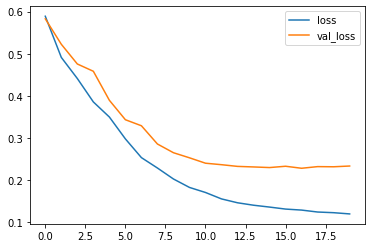

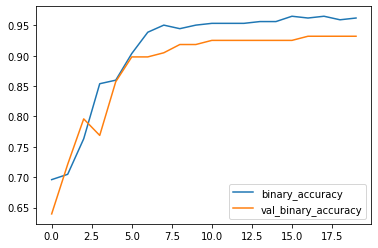

In [ ]:
display_hist(history)  

### Predição 

Para predição, entretanto, podemos empregar agora a rede customizada e não a função `predict` que empregamos anteriormente.

In [ ]:
y_pred = neural_net(X_test) > 0.5

print_results(y_test, y_pred)



Matriz de Confusão: 
 [[125   6]
 [  8  71]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       131
           1       0.92      0.90      0.91        79

    accuracy                           0.93       210
   macro avg       0.93      0.93      0.93       210
weighted avg       0.93      0.93      0.93       210

Acuracidade:  0.9333333333333333


### Treinamento Customizado

Mas o modelo de Subclasses é ainda mais flexível! Você pode customizar quaisquer funções do seu modelo de rede profunda como a função de custo, o otimizador e todo o treinamento da rede.

Não é necessário que você entenda em detalhe todo o código aqui e, se você estiver interessado nisso, pode encontrar mais exemplos na documentação do `Keras`. O mais importante é você entender o **fluxo geral do treinamento** e da **atualização dos pesos da rede** (`run_optimization`) que são os procedimentos gerais empregados para o treinamento de redes profundas tanto no `TensorFlow` como em outros frameworks que implementação uma infraestrutura de programação diferenciável.

In [ ]:
def run_optimization(x, y):
#-------------------------------------------------------------------------------
#
#  
    # with: Envolve a computação dentro do contexto do GradientTape para o AutoGrad ou diferenciação automática 
    with tf.GradientTape() as tape:
        pred = neural_net(x)           # Forward da rede
        loss = loss_fn(y, pred)        # Cálculo da Função Custo
        
    # Define as variáveis que serão atualizadas, i.e. trainable variables ou pesos da rede W e b
    trainable_variables = list(neural_net.trainable_weights)

    # Obtêm os gradientes
    gradients = tape.gradient(loss, trainable_variables)
    
    # Atualiza os pesos W and b de acordo com os gradientes obtidos
    optimizer.apply_gradients(zip(gradients, trainable_variables))
#
#    
#-------------------------------------------------------------------------------


In [ ]:
# Training parameters.
learning_rate = 0.001
training_steps = 100
batch_size = 1 # permite somente o valor 1 aqui
display_step = 10

# Stochastic gradient descent optimizer.
optimizer = tf.optimizers.SGD(learning_rate)

# Função custo
loss_fn = keras.losses.binary_crossentropy 

# Use tf.data API to shuffle and batch data.
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = train_data.repeat().batch(batch_size)
#-------------------------------------------------------------------------------
#
#
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Executa o otimizador para atualizar os pesos da rede W, b
    run_optimization(batch_x, batch_y)
#
#
#-------------------------------------------------------------------------------
    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = loss_fn(batch_y, pred)
        print("step: %i, loss: %f" % (step, loss))

step: 10, loss: 0.040828
step: 20, loss: 0.044010
step: 30, loss: 0.045278
step: 40, loss: 0.041414
step: 50, loss: 0.084430
step: 60, loss: 0.003645
step: 70, loss: 4.386875
step: 80, loss: 0.045398
step: 90, loss: 0.004508
step: 100, loss: 0.050222


In [ ]:
y_pred =  neural_net(X_test) > 0.5

print_results(y_test, y_pred)


Matriz de Confusão: 
 [[125   6]
 [  8  71]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       131
           1       0.92      0.90      0.91        79

    accuracy                           0.93       210
   macro avg       0.93      0.93      0.93       210
weighted avg       0.93      0.93      0.93       210

Acuracidade:  0.9333333333333333


Se você observar o treinamento nada mais é que um laço de programa que itera para cada lote de dados chamando o otimizador. As outras intruções definem configurações como parâmetros e funções, e preparam os dados, ou são para exibição dos resultados. O `TensorFlow` tem uma série de funções para tratamento e transformação dos dados em tensores, definição de lotes, reshape dos dados etc. Acima empregamos a classe `tf.data.Dataset` e você pode consultar a documentação do `TensorFlow` para mais exemplos de como empregá-la.

Mas se o treinamento é apenas um laço que itera o otimizador, nele está a lógica centrla do treinamento do modelo. Você basicamente precisa fazer o *forward* da rede e o cálculo do erro dentro do contexto do gradiente automático para que possam ser calculados os gradientes para cada uma das operações realizadas. Feito isso o otimizador pode atualizar os pesos da rede aplicando os gradientes a todos pesos. Esse é o `backward` da rede e o gradiente automático permite que você faça isso para *qualquer arquitetura* da rede com o mínimo de programação. Será indiferente quantas camadas houverem ou mesmo o tipo de camadas empregadas (convolução, recorrente etc.). Esse é o lado incrível desses frameworks que possibilitam criar um grande número de modelos eficientes com um esforço mínimo.  

#### Funções customizadas

Nesse modo de programação você pode então customizar todo o seu treinamento. Nós, por exemplo, empregamos como função de custo `loss_fn = keras.losses.binary_crossentropy`, mas você poderia escrever sua própria função de custo 
tendo um outro critério para otimizar a rede (por exemplo, empregando alguma métrica de aglomerados (clusterização))





# Voltando ao Modelo Sequencial

Voltando ao modelo sequencial que é a forma mais simples, mas ao mesmo tempo suficiente para construção de modelos do tipo *feed-forward*, vamos rever e fazer mais algumas adições ao nosso modelo Sequencial inicial.

Como você pôde ver a construção de um modelo segue basicamente os seguintes passos:

1. Defina o modelo.
2. Compile o modelo.
3. Treine o modelo.
4. Avalie o modelo.
5. Faça Predições.

Nada muito diferente do quê você aprendeu no uso do `Scikit-learn`. 

Vamos agora rever e adicionar mais algumas melhorias (*) no nosso modelo. 

<small> (*) Essas mudanças não necessariamente levam a um modelo melhor. Não estamos fazendo aqui uma série de execuções dos modelos para compará-los ou empregando qualquer outra técnica de avaliação. Apenas que são configurações úteis para uma série de modelos.</small>

## Adicionando Camadas

Como vimos podemos adicionar várias camadas ao nosso modelo. As camadas de entrada e saída podem requerer um cuidado adicional uma vez que definem o tamanho da entrada dos dados (quantidade de *features* ou atributos) e da saída desejada.

As funções de ativação também podem ser alteradas e uma função muito empregada em modelos de Deep Learning é a função *Relu*. Sendo em parte uma função linear ela é fácil de calcular, incluindo o seu gradiente, sendo muito eficiente para redes com grande número de parâmetros (pesos). Ela entretanto não pode ser empregada para a camada de saída pois pode retornar valores arbitrariamente grandes.

In [ ]:
model = keras.Sequential(layers.Dense(8, activation='relu', input_shape=[9]))

model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 8)                 80        
_________________________________________________________________
dense_9 (Dense)              (None, 16)                144       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 369
Trainable params: 369
Non-trainable params: 0
_________________________________________________________________


## Controlando o Treinamento

Aqui alteramos o otimizador para o *Adam*, um otimizador também bastante popular para modelos de redes neurais. Mas o mais importante aqui é você entender alguns parâmetros que permitem controlar melhor o treinamento do modelo e que encontram-se logo a seguir. Até agora empregamos somente a quantidade de épocas do treinamento.



In [ ]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)

Esses parâmetros estão descritos na documentação do `Keras`:

* **min_delta**: Mudança mínima na quantidade monitorada (a função custo) para qualificar como uma melhoria, ou seja, uma mudança absoluta menor que min_delta, contará como nenhuma mudança ou melhoria.

* **patience**: Número de épocas sem melhora após as quais o treinamento será interrompido. A melhora, emprega o critério do min_delta, acima.

* **restore_best_weights**: se deve restaurar os pesos do modelo da iteração com o melhor valor do valor monitorado. 

In [ ]:
history = model.fit(
    X_train, y_train,
    batch_size=16,
    validation_split=0.3,
    epochs=100,
    callbacks=[early_stopping],
    verbose=0,  
)

,loss,binary_accuracy,val_loss,val_binary_accuracy
0,1.138451,0.312865,0.827241,0.374150
1,0.731032,0.412281,0.630095,0.537415
2,0.600866,0.602339,0.595316,0.680272
3,0.568972,0.742690,0.562148,0.727891
4,0.534924,0.769006,0.523446,0.782313


Best Validation Loss: 0.2127
Best Validation Accuracy: 0.9388


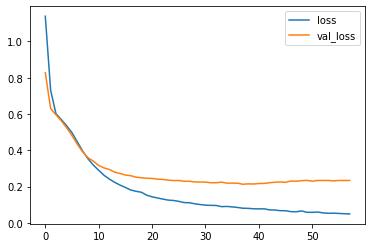

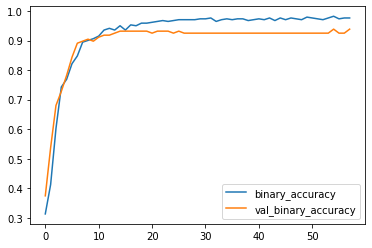

In [ ]:
display_hist(history)  

In [ ]:
y_pred = model.predict(tf.constant(X_test)) > 0.5

print_results(y_test, y_pred)



Matriz de Confusão: 
 [[127   4]
 [  5  74]]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97       131
           1       0.95      0.94      0.94        79

    accuracy                           0.96       210
   macro avg       0.96      0.95      0.95       210
weighted avg       0.96      0.96      0.96       210

Acuracidade:  0.9571428571428572


# Exemplo: Classificação `fraud`

Vamos empregar agora um conjunto de dados de transações de cartão de crédito e fraudes e rever toda a construção de um modelo sequencial para classificação com o `Keras TensorFlow`. 

> Esse banco de dados é o mesmo conjunto de dados empregado em MANAPAT, Michael. **Introduction to Machine Learning with Python**. Em An Introduction to Machine Learning. EMag Edição 50 - Abr 2017. (ver as referências para acesso ao artigo)

## Explorando os dados

Nesse conjunto de dados temos dados de transações de cartão de crédito classificadas como Fraude ou não Fraude. Não empregaremos aqui o atributo `charge_time` no modelo e ao final comentamos mais sobre isso.

In [ ]:
fraud = pd.read_csv("http://meusite.mackenzie.br/rogerio/ML/qconlondon2016_sample_data.csv")
fraud.drop(columns=['charge_time'],inplace=True) 
                     
display(fraud.head())
print(fraud.shape) 
print(fraud.fraudulent.value_counts())


,fraudulent,amount,card_country,card_use_24h
0,False,20484,US,0
1,False,1211,US,0
2,False,8396,US,1
3,False,2359,US,0
4,False,1480,US,3


(89393, 4)
False    45174
True     44219
Name: fraudulent, dtype: int64


Com base nesse conjunto queremos criar um modelo para classificar como fraude ou não as operações baseados unicamente no valor da transação, o país e o uso do cartão nas últimas 24h (uma das variáveis mais importantes na predição de fraudes com cartões de crédito). 

## Preparando os Dados

### Hot Encode `X`

Não existem valores nulos na base, mas o atributo `card_country` é um atributo categórico e precisamos transformá-lo.


In [ ]:
dummies = pd.get_dummies(fraud.card_country)
fraud = pd.concat([fraud, dummies], axis=1)
fraud.drop(columns=['card_country'],inplace=True) 

display(fraud.head())

,fraudulent,amount,card_use_24h,AU,GB,US
0,False,20484,0,0,0,1
1,False,1211,0,0,0,1
2,False,8396,1,0,0,1
3,False,2359,0,0,0,1
4,False,1480,3,0,0,1


### Normalização

Não fizemos isso no modelo de `biopsy`, mas a normalização aqui é necessária já que os valores apresentam escalas muito diferentes e podemos então completar a nossa entrada de dados `X`.

In [ ]:
from sklearn.preprocessing import scale

X = scale(fraud.drop(columns=['fraudulent']))
X


array([[ 0.26867979, -0.17296712, -0.15679634, -0.17828929,  0.2407913 ],
       [-0.19763503, -0.17296712, -0.15679634, -0.17828929,  0.2407913 ],
       [-0.02379224, -0.1280861 , -0.15679634, -0.17828929,  0.2407913 ],
       ...,
       [ 6.07943233,  1.03882041, -0.15679634, -0.17828929,  0.2407913 ],
       [21.1991333 ,  0.99393939, -0.15679634, -0.17828929,  0.2407913 ],
       [-0.12325887,  0.18608104, -0.15679634, -0.17828929,  0.2407913 ]])

Empregamos a função `scale` do `Scikit-learn`, ela leva todos os valores para média zero e desvio padrão 1 e os valores agora estão em formato de uma matriz `Numpy` e podem ser empregadas diretamente no `Keras`. 

### Hot Encode `y`

Apesar do nosso problema ser um problema de classificação binária (Fraude, True ou False) vamos construir aqui um modelo de classificação multiclasse para que você possa compreender esse modelo mais geral. 

Neste caso a classe de saída deve estar representada com o Hot Encode de cada uma das classes. Nosso caso é simples, pois haverão somente duas classes, mas o mesmo pode ser feito para um número arbitrário de classes.

Podemos fazer isso de vários modos, atribuindo diretamente valores aos novos campos, fazendo novamente uso da função `pd.get_dummies` etc. mas vamos empregar aqui uma classe do `Keras` e conhecer mais esse recurso.

In [ ]:
from tensorflow.keras.utils import to_categorical

y = to_categorical(fraud.fraudulent)
y[0:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

### Treinamento e Teste

Preparados os dados vamos criar os conjuntos de treinamento e teste.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [ ]:
X_train

array([[-0.23046796, -0.03832406, -0.15679634, -0.17828929,  0.2407913 ],
       [-0.20259505, -0.17296712, -0.15679634, -0.17828929,  0.2407913 ],
       [-0.20419194,  0.23096206, -0.15679634, -0.17828929,  0.2407913 ],
       ...,
       [-0.22357232, -0.1280861 , -0.15679634, -0.17828929,  0.2407913 ],
       [-0.21217636, -0.08320508, -0.15679634, -0.17828929,  0.2407913 ],
       [-0.18730366, -0.1280861 , -0.15679634, -0.17828929,  0.2407913 ]])

In [ ]:
y_train

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

## Define o Modelo

Nossa rede será uma rede neural sequencial do tipo MLP. Há 5 neurônios de entrada, correspondendo a cada atributo de entrada dos dados e vamos criar duas camadas ocultas de 8 neurônios, e uma camada de saída com 2 neurônios correspondendo às duas classes de saída.





In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [ ]:
# Definição ou Configuração
model = keras.Sequential(layers.Dense(X.shape[1], activation='relu', input_shape=[X.shape[1]]))

model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 48        
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 18        
Total params: 168
Trainable params: 168
Non-trainable params: 0
_________________________________________________________________
None


## Compila o Modelo

Como vamos empregar um modelo de classificação genérico multiclasse vamos empregar a função de custo como `'categorical_crossentropy'` que é o valor mais empregado nesses caso. Aqui adotaremos o otimizador `Adam` e vamos incluir a métrica de acuracidade para acompanhar sua evolução no treinamento do modelo.

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Treinamento do Modelo

Vamos empregar praticamente os mesmos parâmetros do treinamento anterior, mas aumentando o número de épocas do treinamento.

In [ ]:
# Treinamento
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    validation_split=0.3,
    epochs=50,
    callbacks=[early_stopping],
    verbose=0,  
)

,loss,accuracy,val_loss,val_accuracy
0,0.636002,0.666294,0.615233,0.666755
1,0.609219,0.673188,0.610459,0.671763
2,0.607099,0.672709,0.610504,0.670484
3,0.606570,0.674216,0.609352,0.670005
4,0.605941,0.673440,0.608999,0.673094


Best Validation Loss: 0.6076
Best Validation Accuracy: 0.6766


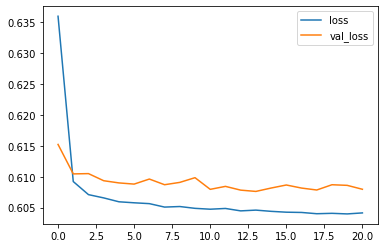

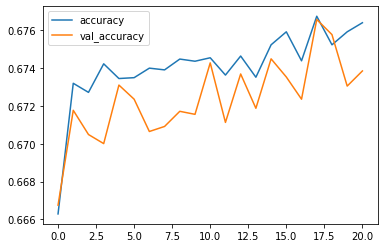

In [ ]:
def display_acc_hist(history):
  history_df = pd.DataFrame(history.history)
  display(history_df.head())
  # Start the plot at epoch 0
  history_df.loc[0:, ['loss', 'val_loss']].plot()
  history_df.loc[0:, ['accuracy', 'val_accuracy']].plot()

  print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_accuracy'].max()))
  return

display_acc_hist(history) 

O resultado desse treinamento, em geral, tem uma acuracidade \< 0.7 para o conjunto de validação e você pode tentar várias modificações nesse modelo e buscar melhorar a sua acuracidade: incluir camadas ou mais elementos, alterar as funções de ativação, empregar outro otimizador etc. 

Você verá que não é tão fácil obter hiperparâmetros que melhorem o resultado do modelo. De fato os modelos profundos são grandes consumidores de dados, eles requerem muitos dados para treinar e, embora tenhamos muitas instâncias de dados aqui, temos muito poucos atributos. Faça a modificação desse modelo empregando o mês da operação do cartão de crédito obtendo o mês do atributo `charge_time` que não empregamos aqui. Você poderá ver um resultado muito melhor e entender que o mês pode ser decisivo na predição das fraudes.

## Avalia o Modelo

Podemos então aplicar e avaliar o modelo no conjunto de teste. Agora cada neurônio de saída da rede retorna a chance de uma classe ou outra. Para obtermos então a predição de classe podemos empregar a função `np.argmax()` para obter a classe mais provável e comparar com os dados de teste.

In [ ]:
model.predict(X_test)

array([[0.40609106, 0.5822438 ],
       [0.5346915 , 0.35688597],
       [0.41762766, 0.59123695],
       ...,
       [0.4790008 , 0.46010312],
       [0.5032303 , 0.4229359 ],
       [0.46556717, 0.4695242 ]], dtype=float32)

In [ ]:
# Predict
import numpy as np

y_pred = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(y_test, axis=1)

print_results(y_test, y_pred)



Matriz de Confusão: 
 [[9804 3819]
 [4846 8349]]
              precision    recall  f1-score   support

           0       0.67      0.72      0.69     13623
           1       0.69      0.63      0.66     13195

    accuracy                           0.68     26818
   macro avg       0.68      0.68      0.68     26818
weighted avg       0.68      0.68      0.68     26818

Acuracidade:  0.6768961145499292


# Código completo

Aqui o código completo em uma única célula com exceção das funções.

,fraudulent,amount,card_country,card_use_24h
0,False,20484,US,0
1,False,1211,US,0
2,False,8396,US,1
3,False,2359,US,0
4,False,1480,US,3


(89393, 4)
False    45174
True     44219
Name: fraudulent, dtype: int64
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 48        
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 18        
Total params: 168
Trainable params: 168
Non-trainable params: 0
_________________________________________________________________
None


,loss,accuracy,val_loss,val_accuracy
0,0.630037,0.663554,0.613736,0.672402
1,0.608773,0.673531,0.613037,0.666755
2,0.607445,0.675312,0.611407,0.670697
3,0.607013,0.674010,0.611395,0.675971
4,0.606691,0.674033,0.611549,0.669951


Best Validation Loss: 0.6079
Best Validation Accuracy: 0.6775
Matriz de Confusão: 
 [[9955 3668]
 [4976 8219]]
              precision    recall  f1-score   support

           0       0.67      0.73      0.70     13623
           1       0.69      0.62      0.66     13195

    accuracy                           0.68     26818
   macro avg       0.68      0.68      0.68     26818
weighted avg       0.68      0.68      0.68     26818

Acuracidade:  0.6776791707062421


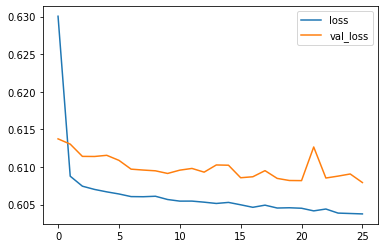

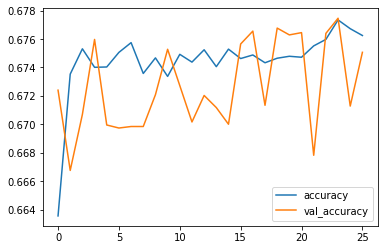

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# Explorando os dados
fraud = pd.read_csv("http://meusite.mackenzie.br/rogerio/ML/qconlondon2016_sample_data.csv")
fraud.drop(columns=['charge_time'],inplace=True) 
                     
display(fraud.head())
print(fraud.shape) 
print(fraud.fraudulent.value_counts())

# Preparando os Dados
# Hot encode
dummies = pd.get_dummies(fraud.card_country)
fraud = pd.concat([fraud, dummies], axis=1)
fraud.drop(columns=['card_country'],inplace=True) 
# Normalização
from sklearn.preprocessing import scale
X = scale(fraud.drop(columns=['fraudulent']))
# Hot encode
from tensorflow.keras.utils import to_categorical
y = to_categorical(fraud.fraudulent)
# Treinamento e Teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

# Define o Modelo
model = keras.Sequential(layers.Dense(X.shape[1], activation='relu', input_shape=[X.shape[1]]))

model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

print(model.summary())

# Compila o Modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treina o Modelo
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True,
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    validation_split=0.3,
    epochs=50,
    callbacks=[early_stopping],
    verbose=0,  
)

display_acc_hist(history) 

# Avalia o Modelo
y_pred = np.argmax(model.predict(X_test), axis=1)
y_test = np.argmax(y_test, axis=1)

print_results(y_test, y_pred)

# Síntese

Nesta trilha você aprendeu o que são os modelos sequenciais e como criar esses modelos para problemas de classificação binária e multiclasse empregando o `Keras TensorFlow`. 

Você conheceu também os diferentes modos de programação do `Keras TensorFlow`: da interface de mais alto nível do modelo Sequencial, o modo da API Funcional, e o modo de Subclasses que permite criar modelos arbitrários de redes e, ainda assim, fazer uso das facilidades de infraestrutura de programação diferenciável do `TensorFlow`. 

É importante que você revise esses códigos. O modelo de SubClasses permitirá a você compreender como é empregada a programação diferenciável do `TensorFlow` no aprendizado dos modelos e é a mesma forma que você encontrará em outros frameworks como o `PyTorch`. E você ainda pode empregar o modelo Sequencial para solução de vários problemas práticos de classificação. 


## Para saber mais

Entenda melhor o que é *Cross Entropy* acessando **Cross-Entropy Demystified**, em https://naokishibuya.medium.com/demystifying-cross-entropy-e80e3ad54a8. 

Quer conhecer mais sobre o otimizador padrão do `TensorFlow` criado por Geoff Hinton, um dos pais do Deep Learning? Então acesse **Understanding RMSprop — faster neural network learning**, em https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a.

Acesse o site https://keras.io/api/models/, **Models API**, e explore exemplos dos diferentes modos de construção de redes profundas com o `Keras TensorFlow`. 

Entenda mais sobre que outras arquiteturas de rede podem ser construídas com o modo de programação da API Funcional do `Keras TensorFlow` lendo **3 ways to create a Machine Learning model with Keras and TensorFlow 2.0 (Sequential, Functional, and Model Subclassing)**, em https://towardsdatascience.com/3-ways-to-create-a-machine-learning-model-with-keras-and-tensorflow-2-0-de09323af4d3. 


## Referências

1. Aston Zhang and Zachary C. Lipton and Mu Li and Alexander J. Smola. **Dive into Deep Learning** (2020). Disponível em: https://d2l.ai/index.html Acesso em: 21 de abril de 2021. 

1. ___. **Tensors**. Disponível em: https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html  Acesso em: 28 de maio de 2021.

1. Géron, A. **Hands-on machine learning with Scikit-Learn, Keras and TensorFlow: concepts, tools, and techniques to build intelligent systems**, 2nd ed. (2019) O'Reilly 

1. Ramsundar, B., Zadeh, R. B. **TensorFlow for Deep Learning** (2016), O'Reilly Media, Inc. 

1. Manapat, Michael. **Introduction to Machine Learning with Python**. Em An Introduction to Machine Learning. EMag Edição 50 - Abr 2017.  Disponível em: http://meusite.mackenzie.br/rogerio/ML/The-InfoQ-eMag-Introduction-to-Machine-Learning.pdf Acesso em: 29 de maio de 2021.

1. ___.**Keras Models API**. Disponível em: https://keras.io/api/models/, Acesso em: 29 de maio de 2021. 

1. ___.**Keras Layers API**. Disponível em: https://keras.io/api/layers/, Acesso em: 29 de maio de 2021. 

1. ___.**Keras Callbacks API**. Disponível em: https://keras.io/api/callbacks/, Acesso em: 29 de maio de 2021. 

